In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Get data into dataframe
df = pd.read_csv('WMA_fractions_v2.csv', skiprows=1)

# Preprocess data to only have temperature, salinity and dissolved oxygen
df_TSO = df.copy()
df_TSO = df_TSO[['Conservative_Temperature_[deg_C]', 'Absolute_Salinity_[PSU]', 'Dissolved_Oxygen_[micro_mol_per_kg]', 'Latitude_[deg_N]', 'Longitude_[deg_E]']]
# df_TSO = df_TSO[['Conservative_Temperature_[deg_C]', 'Absolute_Salinity_[PSU]', 'Dissolved_Oxygen_[micro_mol_per_kg]']]
df_TSO = df_TSO.dropna()

In [3]:
# # chatgpt function to sample by lat lon bins

# import pandas as pd
# import numpy as np

# def sample_by_lat_lon_bins(
#     df,
#     bin_sizes=(2, 2),
#     total_samples=None,
#     fraction=None,
#     strategy="equal",   # "equal" or "proportional"
#     replace=False,
#     random_state=None
# ):
#     lat_size, lon_size = bin_sizes

#     # Determine how many samples
#     if fraction is not None:
#         total_samples = int(round(len(df) * fraction))
#     if total_samples is None:
#         total_samples = len(df)

#     df = df.copy()

#     # Build bins
#     lat_bins = np.arange(df.lat.min(), df.lat.max() + lat_size, lat_size)
#     lon_bins = np.arange(df.lon.min(), df.lon.max() + lon_size, lon_size)

#     df["_lat_bin"] = pd.cut(df["lat"], bins=lat_bins, include_lowest=True)
#     df["_lon_bin"] = pd.cut(df["lon"], bins=lon_bins, include_lowest=True)

#     # Drop unbinned rows
#     df_binned = df.dropna(subset=["_lat_bin", "_lon_bin"])

#     # Group by bins
#     grouped = df_binned.groupby(["_lat_bin", "_lon_bin"], observed=True)

#     # Extract bin info directly from the groups
#     bins = []
#     counts = []
#     for key, group in grouped:
#         bins.append(key)          # key = (lat_interval, lon_interval)
#         counts.append(len(group))

#     bin_info = pd.DataFrame({"bin": bins, "count": counts})
#     n_bins = len(bin_info)

#     # Allocate samples
#     if strategy == "equal":
#         base = total_samples // n_bins
#         remainder = total_samples - base * n_bins
#         bin_info["target"] = base
#         if remainder > 0:
#             bin_info.loc[:remainder - 1, "target"] += 1

#     elif strategy == "proportional":
#         total_count = bin_info["count"].sum()
#         raw = bin_info["count"] / total_count * total_samples
#         bin_info["target"] = np.floor(raw).astype(int)
#         remainder = total_samples - bin_info["target"].sum()
#         if remainder > 0:
#             frac = raw - np.floor(raw)
#             idx = np.argsort(-frac)[:remainder]
#             bin_info.loc[idx, "target"] += 1

#     else:
#         raise ValueError("strategy must be 'equal' or 'proportional'")

#     # --- SAMPLE ---
#     sampled_parts = []
#     for (lat_bin, lon_bin), target in zip(bin_info["bin"], bin_info["target"]):
#         group = grouped.get_group((lat_bin, lon_bin))

#         # Sample without replacement until group limit
#         if (len(group) < target) and not replace:
#             sampled_parts.append(group)
#         else:
#             sampled_parts.append(group.sample(target, replace=replace, random_state=random_state))

#     sampled_df = pd.concat(sampled_parts).reset_index(drop=True)

#     # Clean temporary columns
#     sampled_df = sampled_df.drop(columns=["_lat_bin", "_lon_bin"])

#     return sampled_df


In [4]:
# sampled_df = sample_by_lat_lon_bins(df_TSO.rename(columns={'Latitude_[deg_N]': 'lat', 'Longitude_[deg_E]': 'lon'}), total_samples=100000, bin_sizes=(2,60), strategy="equal", random_state=22)

In [ ]:
# Sampling function
def geo_uniform_sampler(df, n_samples, lat_name='Latitude_[deg_N]', lon_name='Longitude_[deg_E]', n_grid_hw=1000, random_state=None):
    """
    Samples the dataframe uniformly across the geographic projection, by emplying latitude and longitude bins.

    Args:
    - df (pd.DataFrame): Input dataframe with 'Latitude_[deg_N]' and 'Longitude_[deg_E]' columns.
    - n_samples (int): Total number of samples to draw.
    - lat_name (str): Name of the latitude column. Default is 'Latitude_[deg_N]'.
    - lon_name (str): Name of the longitude column. Default is 'Longitude_[deg_E]'.
    - n_grid_hw (int): Number of grid cells in latitude and longitude directions (height and width
        assumed to be square: n_grid_cells x n_grid_cells. Default is 1000.

    Returns:
        pd.DataFrame: Sampled dataframe.
    """

    if random_state is not None:
        np.random.seed(random_state)
    
    df = df.copy()

    # Create latitude and longitude bins
    lat_min, lat_max = df[lat_name].min(), df[lat_name].max()
    lon_min, lon_max = df[lon_name].min(), df[lon_name].max()

    # Create bins
    lat_bins = np.linspace(lat_min, lat_max, n_grid_hw + 1)
    lon_bins = np.linspace(lon_min, lon_max, n_grid_hw + 1)

    # Assign each point (row) to a bin
    df['_lat_bin'] = pd.cut(df[lat_name], bins=lat_bins, labels=False, include_lowest=True)
    df['_lon_bin'] = pd.cut(df[lon_name], bins=lon_bins, labels=False, include_lowest=True)
    df['_bin'] = df['_lat_bin'].astype(str) + '_' + df['_lon_bin'].astype(str)

    # Count points in each bin
    bin_counts = df['_bin'].value_counts()
    n_bins = len(bin_counts)

    # Determine number of samples per bin (uniform distribution)
    samples_per_bin = n_samples / n_bins

    # Sample from each bin proportionally to get uniform geographic distribution
    sampled_dfs = []
    bins_to_boost = []

    for i, bin_id in enumerate(bin_counts.index):
        bin_df = df[df['_bin'] == bin_id]



        # Calculate number of samples to draw from this bin
        
        
#rrr


In [4]:
import pandas as pd
import numpy as np
from typing import Tuple, Optional

def uniform_geographic_sample(
    df: pd.DataFrame,
    n_samples: int,
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
    n_grid_cells: int = 50,
    random_state: Optional[int] = None) -> pd.DataFrame:
    """
    Sample points from a dataset to minimize spatial density variability.
    
    Uses grid-based stratified sampling to ensure uniform geographic coverage.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with geographic coordinates
    n_samples : int
        Number of samples to draw
    lat_col : str
        Name of the latitude column
    lon_col : str
        Name of the longitude column
    n_grid_cells : int
        Number of grid cells per dimension (creates n_grid_cells x n_grid_cells grid)
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    pd.DataFrame
        Sampled dataframe with uniform spatial distribution
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    df = df.copy()
    
    # Get coordinate bounds
    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()
    
    # Create grid cells
    lat_bins = np.linspace(lat_min, lat_max, n_grid_cells + 1)
    lon_bins = np.linspace(lon_min, lon_max, n_grid_cells + 1)
    
    # Assign each point to a grid cell
    df['_lat_bin'] = pd.cut(df[lat_col], bins=lat_bins, labels=False, include_lowest=True)
    df['_lon_bin'] = pd.cut(df[lon_col], bins=lon_bins, labels=False, include_lowest=True)
    df['_grid_cell'] = df['_lat_bin'].astype(str) + '_' + df['_lon_bin'].astype(str)
    
    # Count points per grid cell
    cell_counts = df['_grid_cell'].value_counts()
    occupied_cells = len(cell_counts)
    
    # Calculate target samples per cell for uniform distribution
    samples_per_cell = n_samples / occupied_cells
    
    # Strategy: Sample equally from each occupied cell for uniform coverage
    # First pass: try to take equal samples from each cell
    base_samples_per_cell = n_samples // occupied_cells
    extra_samples = n_samples % occupied_cells
    
    sampled_dfs = []
    cells_to_boost = []
    
    for i, cell_id in enumerate(cell_counts.index):
        cell_df = df[df['_grid_cell'] == cell_id]
        
        # Base samples for this cell
        n_from_cell = base_samples_per_cell
        
        # Distribute extra samples to first few cells
        if i < extra_samples:
            n_from_cell += 1
        
        # Can't sample more than available in cell
        n_from_cell = min(n_from_cell, len(cell_df))
        
        if n_from_cell > 0:
            sampled = cell_df.sample(n=n_from_cell, replace=False)
            sampled_dfs.append(sampled)
        
        # Track if this cell couldn't provide enough samples
        if n_from_cell < base_samples_per_cell + (1 if i < extra_samples else 0):
            deficit = (base_samples_per_cell + (1 if i < extra_samples else 0)) - n_from_cell
            cells_to_boost.append(deficit)
    
    # Combine all samples
    result = pd.concat(sampled_dfs, ignore_index=True)
    
    # If we have a deficit, sample more from cells that have remaining points
    if len(result) < n_samples:
        remaining_df = df[~df.index.isin(result.index)]
        if len(remaining_df) > 0:
            additional_needed = n_samples - len(result)
            additional = remaining_df.sample(n=min(additional_needed, len(remaining_df)), replace=False)
            result = pd.concat([result, additional], ignore_index=True)
    
    # Remove helper columns
    result = result.drop(columns=['_lat_bin', '_lon_bin', '_grid_cell'])
    
    return result

In [5]:
df_sampled = uniform_geographic_sample(df_TSO, n_samples=100000, lat_col='Latitude_[deg_N]', lon_col='Longitude_[deg_E]', n_grid_cells=100, random_state=22)

In [7]:
df_TSO.head()

,Conservative_Temperature_[deg_C],Absolute_Salinity_[PSU],Dissolved_Oxygen_[micro_mol_per_kg],Latitude_[deg_N],Longitude_[deg_E]
450,7.568,35.200,299.264,69.893,3.994
451,7.529,35.199,298.703,69.870,3.930
452,6.170,35.250,296.322,69.895,3.919
453,6.138,35.252,295.827,69.870,4.025
454,6.091,35.252,295.818,69.884,3.960


In [6]:
import plotly.express as px

# Compute data centroid (mean location)
# center_lat = df_TSO['Latitude_[deg_N]'].mean()
# center_lon = df_TSO['Longitude_[deg_E]'].mean()
center_lat = df_sampled['Latitude_[deg_N]'].mean()
center_lon = df_sampled['Longitude_[deg_E]'].mean()

print("Center lat:", center_lat, "Center lon:", center_lon)

# Use labels from kmeans clustering on data to plot geographically
fig3 = px.scatter_geo(
    df_sampled,
    lat='Latitude_[deg_N]',
    lon='Longitude_[deg_E]',
    title="Sampled data in geographic space"
)

fig3.update_geos(
    projection_type="orthographic",
    projection_rotation=dict(lat=center_lat, lon=center_lon),
    showcoastlines=True,
    showcountries=True
)

fig3.update_layout(height=800, width=800)
fig3.show()

Center lat: 79.81604592 Center lon: -50.949791180000005


In [7]:
# Extract values into a tensor
X = torch.tensor(df_sampled.values, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [8]:
# Define Variational Autoencoder

class VAE(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 16)
        self.fc3 = nn.Linear(16, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h)     # no sigmoid for real-valued data

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
# Define loss function (mse and KL divergence)
def vae_loss(recon_x, x, mu, logvar):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kld

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VAE(input_dim=5, latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch in loader:
        x = batch[0].to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)

        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(dataset):.4f}")

Epoch 1 | Loss: 11027.9811
Epoch 2 | Loss: 587.8068
Epoch 3 | Loss: 270.1268
Epoch 4 | Loss: 204.5586
Epoch 5 | Loss: 171.7632
Epoch 6 | Loss: 153.1125
Epoch 7 | Loss: 137.5652
Epoch 8 | Loss: 123.9643
Epoch 9 | Loss: 111.1187
Epoch 10 | Loss: 97.0528
Epoch 11 | Loss: 87.5552
Epoch 12 | Loss: 81.5037
Epoch 13 | Loss: 77.1509
Epoch 14 | Loss: 74.1811
Epoch 15 | Loss: 71.4229
Epoch 16 | Loss: 69.5548
Epoch 17 | Loss: 67.5207
Epoch 18 | Loss: 66.6644
Epoch 19 | Loss: 65.2754
Epoch 20 | Loss: 64.0200
Epoch 21 | Loss: 63.5545
Epoch 22 | Loss: 62.6906
Epoch 23 | Loss: 61.6212
Epoch 24 | Loss: 61.3727
Epoch 25 | Loss: 60.4093
Epoch 26 | Loss: 60.0761
Epoch 27 | Loss: 59.8193
Epoch 28 | Loss: 58.8198
Epoch 29 | Loss: 58.8963
Epoch 30 | Loss: 58.4536
Epoch 31 | Loss: 58.1220
Epoch 32 | Loss: 57.8398
Epoch 33 | Loss: 57.4970
Epoch 34 | Loss: 56.8294
Epoch 35 | Loss: 57.0114
Epoch 36 | Loss: 56.3321
Epoch 37 | Loss: 56.3434
Epoch 38 | Loss: 55.9471
Epoch 39 | Loss: 55.9647
Epoch 40 | Loss: 55.477

In [11]:
model.eval()
with torch.no_grad():
    mu, logvar = model.encode(X.to(device))
    z = mu.cpu()   # latent representation

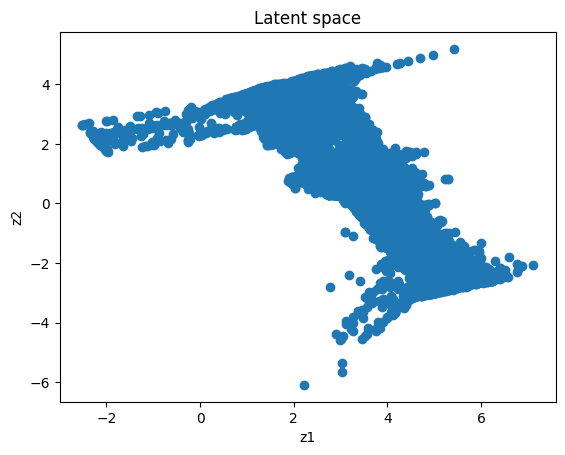

In [12]:
plt.scatter(z[:,0].cpu().tolist(), z[:,1].cpu().tolist())
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Latent space")
plt.show()

In [13]:
with torch.no_grad():
    recon = model(X.to(device))[0].cpu()

In [14]:
df_recon = pd.DataFrame(recon.numpy(), columns=df_sampled.columns)

In [15]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=22)
gmm.fit(recon)
gmm_labels = gmm.predict(recon)
df_recon['gmm_label'] = gmm_labels.astype(str)

/Users/franciscagomes/PhD/WM_class/.venv/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




In [16]:
import plotly.express as px

# Compute data centroid (mean location)
# center_lat = df_TSO['Latitude_[deg_N]'].mean()
# center_lon = df_TSO['Longitude_[deg_E]'].mean()
center_lat = df_sampled['Latitude_[deg_N]'].mean()
center_lon = df_sampled['Longitude_[deg_E]'].mean()

print("Center lat:", center_lat, "Center lon:", center_lon)

# Use labels from kmeans clustering on data to plot geographically
fig3 = px.scatter_geo(
    df_recon,
    lat='Latitude_[deg_N]',
    lon='Longitude_[deg_E]',
    color='gmm_label',
    title="Gaussian Mixture Model on VAE lattent space geographic projection"
)

fig3.update_geos(
    projection_type="orthographic",
    projection_rotation=dict(lat=center_lat, lon=center_lon),
    showcoastlines=True,
    showcountries=True
)

fig3.update_layout(height=800, width=800)
fig3.show()

Center lat: 79.81604592 Center lon: -50.949791180000005
